In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.append('../main/')
from multi_py.multi import *
import numpy as np
import sys  
from os.path import dirname, join as pjoin
import scipy.io as sio
from scipy.io import readsav
import copy
import pandas as pd
import os
from scipy import integrate
from scipy.signal import argrelextrema
from scipy import interpolate
from scipy import optimize
import pickle
from itertools import product
from matplotlib.ticker import FormatStrFormatter
from shapely.geometry import LineString


%config InlineBackend.figure_format='svg'
plt.style.use('default')
plt.style.use('../main/multi_py/Bergemann2020.mplstyle')

In [2]:
major_krs = [286, 291, 293, 299, 427] # 292 and 302 removed - empty gaps; 457 removed - does not appear in the ref paper
sol_mus = [1.0, 0.9, 0.8, 0.6, 0.4, 0.2]


## Read in observed spectrum

In [3]:
sav_fname = pjoin('../../data/spectra/1631885174310_iag_sun_Si.sav')
sav_data = readsav(sav_fname)
# f = open('../../data/spectra/sun_kpnomu1_6000_8000A.txt')
# obs_spec2 = np.loadtxt(fname=f)
# f.close()

In [4]:
# simulation has been run with mus: 1, 0.9, 0.8, 0.6, 0.4, 0.2
# specify the indecies corresponding to these angles in the solar data
sol_mu_ind = [0, 4, 5, 7, 9, 11]
# get the flux(intensity) and wavelengths corresponding to these angles
sol_fluxes = [sav_data['iag_sun'].flux[0][ang] for ang in sol_mu_ind]
sol_lams = [sav_data['iag_sun'].wave[0][ang] for ang in sol_mu_ind]
sol_mus = [sav_data['iag_sun'].mu[0][ang] for ang in sol_mu_ind]

In [5]:
with open('../mdata/sol_int_renorm', "rb") as f:
    sol_int_renorm = pickle.load(f)
    
with open('../mdata/sol_lam_range_list', "rb") as f:
    sol_lam_range_list = pickle.load(f)

with open('../mdata/new_eq_iag', "rb") as f:
    new_eq_iag = pickle.load(f)


## Read in simulated spectrum

In [6]:
def get_lines(thisrun, krs):
    lines = []
    for kr in krs:
        lines.append(thisrun.line[kr])
    return lines

In [7]:
# runfiles = ['../runs/Si_marcs_LTE_mus/output/', '../runs/Si_stag_NLTE_5x5x230_mus/output/', '../runs/Si_stag_NLTE_10x230_mu_iter/output','../runs/SiStagNLTE_10_f3Dold/output','../runs/Si_stag_NLTE_30_old/output']
runfiles = ['../runs/Si_marcs_LTE_mus/output/', '../runs/SiStagNLTE_30_f3Dold/output/']
# runfiles = ['../runs/Si_marcs_LTE_mus/output/', '../runs/Amarsi2017_F/SiMarcsLTE/output/']

# runfiles = ['../runs/iosmet_runs/SiMarcsLTE/output/', '../runs/iosmet_runs/SiStagNLTE30_full3D/output/']

labels=['1D LTE', '3D NLTE']
# labels = [ '1D LTE', 'stag5old1.5D', 'stag10old1.5D', 'stag5oldf3D', 'stag30old1.5D']
runobjects = [m3d(thisrun, lines=major_krs, conts=[]) for thisrun in runfiles]
linesobj = [get_lines(thisrunobj, major_krs) for thisrunobj in runobjects]

Completed reading parameters from ../runs/SiStagNLTE_30_f3Dold/output//


In [8]:
# Read in 1D NLTE spectra for plotting
run_1DNLTE = '../runs/SiMarcs1DNLTE/output/'
runobj_1DNLTE = m3d(run_1DNLTE, lines=major_krs, conts=[])
line_obj_1DNLTE = get_lines(runobj_1DNLTE, major_krs)
# Read in 3D LTE spectra
run_3DLTE = '../runs/Si_stag_LTE30_f3D/output'
runobj_3DLTE = m3d(run_3DLTE, lines=major_krs, conts=[])
lines_obj_3DLTE = get_lines(runobj_3DLTE, major_krs)

Completed reading parameters from ../runs/Si_stag_LTE30_f3D/output/


In [9]:
wavelengths = [line.lam0 for line in linesobj[0]]
m3d_centre_wavelengths = [5645.613, 5684.484, 5701.104, 5772.146, 7034.901]

In [10]:
def get_ang_intensity(run, kr):
    sim_fluxes = [run.line[kr].i3[:,1]]
    for i, _ in enumerate(sol_mu_ind[1:]):
        ang=i+1
        ang_idx = (ang-1)*4+1
        sim_fluxes.append(np.mean(run.line[kr].i3[:, ang_idx:ang_idx+4], axis=-1))
    return sim_fluxes

## Plot input line profiles

In [11]:
# def plot_mu_intensities(line_ind):
#     # define the wavelength range for this line with the m3d central wavelenght:
#     line_lam = copy.deepcopy(linesobj[0][line_ind].lam)
#     line_lam += m3d_centre_wavelengths[line_ind] - linesobj[0][line_ind].lam0

#     sim_int_1d = get_ang_intensity(runobjects[0], kr=major_krs[line_ind])
#     sim_int_1d_norm = sim_int_1d/continuum(line_lam, np.array(sim_int_1d))
#     sim_int_3d = get_ang_intensity(runobjects[1], kr=major_krs[line_ind])
#     sim_int_3d_norm = sim_int_3d/continuum(line_lam, np.array(sim_int_3d))

#     fig, ax = plt.subplots(len(sol_mu_ind), 1, figsize=(17,25))

#     for i, mu in enumerate(sol_mu_ind):
#         # plot 1D LTE with cmacroturbulence onvolution Vmac = 3km
#         ax[i].plot(line_lam, sim_int_1d_norm[i], label=f'1D LTE')
#         ax[i].plot(*convol(line_lam, sim_int_1d_norm[i], zeta_rt=3), label=f'1D LTE conv')

#         ax[i].plot(line_lam, sim_int_3d_norm[i], label=f'3D NLTE') 

        
#         ax[i].plot(sol_lams[i], sol_fluxes[i], linestyle='none', marker='.', zorder=100, label=f'IAG solar spec')

        
#         plt.sca(ax[i])
#         plt.title(f'Line = {m3d_centre_wavelengths[line_ind]}, mu = {sol_mus[i]:.2f}')
#         plt.xlim((m3d_centre_wavelengths[line_ind]-0.35), (m3d_centre_wavelengths[line_ind]+0.35))
#         plt.ylim(0.35,1.05)
#         plt.ylabel('Normalised Intensity')
#         plt.xlabel('λ (Å)')
#         plt.legend()
# #     fig.savefig('../plots/kr5645_1.5D.pdf')

In [12]:
# def plot_mu_intensities(line_ind):
#     # define the wavelength range for this line with the m3d central wavelenght:
#     line_lam = copy.deepcopy(linesobj[0][line_ind].lam)
#     line_lam += m3d_centre_wavelengths[line_ind] - linesobj[0][line_ind].lam0

#     # get the resolved intensities for the simulated spectra
#     sim_ints_norm_list = []
#     for i,run in enumerate(runobjects):
#         sim_int = get_ang_intensity(runobjects[i], kr=major_krs[line_ind])
#         sim_ints_norm = sim_int/continuum(line_lam, np.array(sim_int))
#         sim_ints_norm_list.append(sim_ints_norm)


#     # sim_int_1d = get_ang_intensity(runobjects[0], kr=major_krs[line_ind])
#     # sim_int_1d_norm = sim_int_1d/continuum(line_lam, np.array(sim_int_1d))
#     # sim_int_3d = get_ang_intensity(runobjects[1], kr=major_krs[line_ind])
#     # sim_int_3d_norm = sim_int_3d/continuum(line_lam, np.array(sim_int_3d))

#     fig, ax = plt.subplots(len(sol_mu_ind), 1, figsize=(17,25))

#     for i, mu in enumerate(sol_mu_ind):
#         for j, run in enumerate(sim_ints_norm_list):
#             ax[i].plot(line_lam, sim_ints_norm_list[j][i], label=labels[j])
#             if j==0:
#             # plot 1D LTE with cmacroturbulence onvolution Vmac = 3km
#              ax[i].plot(*convol(line_lam, sim_ints_norm_list[j][i], zeta_rt=3), label=f'1D LTE conv')


        
#         ax[i].plot(sol_lams[i], sol_fluxes[i], linestyle='none', marker='.', zorder=100, label=f'IAG solar spec')

        
#         plt.sca(ax[i])
#         plt.title(f'Line = {m3d_centre_wavelengths[line_ind]}, mu = {sol_mus[i]:.2f}')
#         plt.xlim((m3d_centre_wavelengths[line_ind]-0.35), (m3d_centre_wavelengths[line_ind]+0.35))
#         plt.ylim(0.35,1.05)
#         plt.ylabel('Normalised Intensity')
#         plt.xlabel('λ (Å)')
#         plt.legend()
#     # fig.savefig('line1_mudep.pdf')

## Normalise Simulated Spectra

In [13]:
# sim_int_1d_norm_ar = np.zeros((len(major_krs), len(sol_mus)))
sim_int_1d_norm_ar = {}
sim_int_3d_norm_ar = {}
line_lams = {}
# sim_int_3d_norm_ar = np.zeros((len(major_krs), len(sol_mus)))
sim_int_1dnlte_norm_ar = {}
sim_int_3dlte_norm_ar = {}
sim_int_1d_dict = {}
sim_int_3dnlte_dict = {}
sim_int_3dlte_dict = {}


for k, _ in enumerate(major_krs):
        line_lam = copy.deepcopy(linesobj[0][k].lam)
        line_lam += m3d_centre_wavelengths[k] - linesobj[0][k].lam0
        line_lams[k] = line_lam

        sim_int_1d = get_ang_intensity(runobjects[0], kr=major_krs[k])
        sim_int_1d_dict[k] = sim_int_1d
        # sim_int_1d_norm_ar[k].append(sim_int_1d/continuum(line_lam, np.array(sim_int_1d))
        sim_int_1d_norm_ar[k] = sim_int_1d/continuum(line_lam, np.array(sim_int_1d))
        # sim_int_1d_norm_ar = np.stack((sim_int_1d/continuum(line_lam, np.array(sim_int_1d)),sim_int_1d_norm_ar))
        sim_int_3dnlte = get_ang_intensity(runobjects[1], kr=major_krs[k])
        sim_int_3dnlte_dict[k] = sim_int_3dnlte
        # sim_int_3d_norm_ar[k,:] = sim_int_3d/continuum(line_lam, np.array(sim_int_3d))
        sim_int_3d_norm_ar[k] = sim_int_3dnlte/continuum(line_lam, np.array(sim_int_3dnlte))

        # 1D NLTE
        sim_int_1dnlte = get_ang_intensity(runobj_1DNLTE, kr=major_krs[k])
        sim_int_1dnlte_norm_ar[k] = sim_int_1dnlte/continuum(line_lam, np.array(sim_int_1dnlte))

        # 3D LTE
        sim_int_3dlte = get_ang_intensity(runobj_3DLTE, kr=major_krs[k])
        sim_int_3dlte_dict[k] = sim_int_3dlte
        sim_int_3dlte_norm_ar[k] = sim_int_3dlte/continuum(line_lam, np.array(sim_int_3dlte))



In [14]:
# with open('../mdata/normalised_intensities/1DLTE', 'wb') as f:
#     pickle.dump(sim_int_1d_norm_ar, f)
# with open('../mdata/normalised_intensities/1DNLTE', 'wb') as f:
#     pickle.dump(sim_int_1dnlte_norm_ar, f)
# with open('../mdata/normalised_intensities/3DLTE', 'wb') as f:
#     pickle.dump(sim_int_3d_norm_ar, f)
# with open('../mdata/normalised_intensities/3DNLTE', 'wb') as f:
#     pickle.dump(sim_int_3dlte_norm_ar, f)
# with open('../mdata/line_lams', 'wb') as f:
#     pickle.dump(line_lams, f)
# with open('../mdata/sol_mus', 'wb') as f:
#     pickle.dump(sol_mus, f)

## B&W profile grid plot

In [17]:
# plot line profiles with before and after normalisation
plot=False
if plot==True:
    plt.rcParams.update({'font.size': 13})

    fig, ax = plt.subplots(len(sol_mus), len(major_krs), figsize=(13,15), sharex='col', sharey='row')


    for i, thismu in enumerate(sol_mus):

        for j, line_i in enumerate(major_krs):

            ax[i,j].scatter(sol_lam_range_list[j,i], sol_int_renorm[j,i],marker='.',s=65,zorder=1, color='lightgray', label='IAG')
            ax[i,j].plot(*convol(line_lams[j], sim_int_1d_norm_ar[j][i], zeta_rt=3), label='1D LTE', color='k', linestyle=':',linewidth='2')
            ax[i,j].plot(line_lams[j], sim_int_3d_norm_ar[j][i], label='3D NLTE', color='k', linestyle='-',linewidth='2')
            
            ax[i,j].set_xlim((m3d_centre_wavelengths[j]-0.3), (m3d_centre_wavelengths[j]+0.3))
            ax[i,j].set_xticks(ticks=np.linspace(m3d_centre_wavelengths[j]-0.25, m3d_centre_wavelengths[j]+0.25,3) ,labels=np.linspace(-0.25,0.25,3))

            # ax[i,j].legend(fontsize=10)
            plt.sca(ax[i,j])
            plt.ylim(0.35,1.03) 
            if i == 0:
                ax[i,j].set_title(f'{m3d_centre_wavelengths[j]:.2f} Å')
            if i == len(sol_mus)-1:
                ax[i,j].set_xlabel('$\Delta \lambda$ Å')
            if j == 0:
                ax[i,j].set_ylabel(f'$\mu = {thismu:.1f}$')
                ax[i,j].legend(fontsize=10)
    
    fig.supylabel('Normalised Intensity', fontsize=15)
    plt.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)

    # fig.savefig('../plots/prof_grid_sim_supy.pdf')

## Read in CoG simulated spectra and calculate EWs

In [18]:
LTE_runs = '../runs/Si_marcs_LTE_dir/'
# LTE_runs = '../runs/iosmet_runs/SiMarcsLTEdir/'
# LTE_runs = '../runs/Amarsi2017_F/SiMarcsLTEdir/'

LTE1d_cog = CoG(runs=LTE_runs, lines=major_krs)

Completed reading parameters from ../runs/Si_marcs_LTE_dir//7.76//output//


In [27]:
def get_cog_eqw(cogobj, kr, qmax, define_mask):
    all_eqws =  [cogobj.calc_weq(kr=kr, qmax=qmax, ang=ang, norm=True, define_mask=define_mask) for ang in range((4*len(sol_mus[1:])+1))]
    # print(all_eqws)
    kr_eqws = [all_eqws[0]]
    # print(kr_eqws)
    for mu, _ in enumerate(sol_mus[1:]):
        ang_start = mu*4+1
        ang_end = ang_start+4
        kr_eqws.append(np.mean(all_eqws[ang_start:ang_end], axis=0))
        # print(f'{ang_start}:{ang_end}')
        # print(f'range-{all_eqws[ang_start]}:{all_eqws[ang_end-1]}')
    return kr_eqws

In [28]:
# define the integration limits for the iag observed solar spectrum for each line (keep same across angles)
iag_int_lims = np.array([[5645.4, 5645.8],[5684.31,5684.7],[5700.97,5701.3],[5771.9,5772.35],[7034.55,7035.2]])

In [29]:
def get_line_eqw(linesobject, line, qmax, define_mask):
    all_eqws =  [linesobject[line].calc_weq(qmax=qmax, ang=ang, norm=True, define_mask=define_mask) for ang in range((4*len(sol_mus[1:])+1))]
    line_eqws = [all_eqws[0]]
    for mu, _ in enumerate(sol_mus[1:]):
        ang_start = mu*4+1
        ang_end = ang_start+4
        line_eqws.append(np.mean(all_eqws[ang_start:ang_end]))
        # print(f'{all_corrs[ang_start]}:{all_corrs[ang_end-1]}')
    return line_eqws

In [30]:
# eqwidths_1dlte = np.array([[test_cog.calc_weq(kr=kr, ang=ang, qmax=3.5, norm=True) for ang in range(len(mu_zs))] for kr in major_krs])
eqwidths_1dlte = np.array([get_cog_eqw(cogobj=LTE1d_cog, kr=thiskr, qmax=40, define_mask=iag_int_lims[kr_i]) for kr_i, thiskr in enumerate(major_krs)])


## 1D LTE run using Amarsi 2017 atom file changes

In [31]:
# Ama_1DLTE_runfile = '../runs/Amarsi2017_F/SiMarcsLTE/output/'
# Ama_1DLTE_runobj = m3d(Ama_1DLTE_runfile, lines=major_krs, conts=[])
# Ama_1DLTE_lines = get_lines(Ama_1DLTE_runobj, major_krs)

In [32]:
# Ama_1DLTE_EWs = [get_line_eqw(linesobject=Ama_1DLTE_lines, line=thisline, qmax=3.5) for thisline in range(len((Ama_1DLTE_lines)))]

In [33]:
# Ama_1DLTE_EWs[0]

## Plot EWs vs mu angles for CoG 1D LTE, 3D NLTE and observed spectra


In [34]:
NLTE3d_runfile = '../runs/SiStagNLTE_30_f3Dold/output/'
NLTE3d_runobj = m3d(NLTE3d_runfile, lines=major_krs, conts=[])
NLTE3d_lines = get_lines(NLTE3d_runobj, major_krs)

Completed reading parameters from ../runs/SiStagNLTE_30_f3Dold/output//


In [35]:
NLTE3d_EWs = [get_line_eqw(linesobject=NLTE3d_lines, line=thisline, qmax=40, define_mask=iag_int_lims[thisline]) for thisline in range(len((NLTE3d_lines)))]

In [52]:
NLTE3d_EWs[-1]

[13.523604494461969,
 15.111645171083861,
 15.000107047962622,
 14.637340220489982,
 13.602400658226891,
 11.62580572449437]

In [54]:
lam_mask = [np.logical_and((line_lams[4] > iag_int_lims[4,0]), (line_lams[4] < iag_int_lims[4,1]))]
xx = (line_lams[4])[tuple(lam_mask)]
yy =  (sim_int_3d_norm_ar[4][0])[tuple(lam_mask)]

78.36734335663664


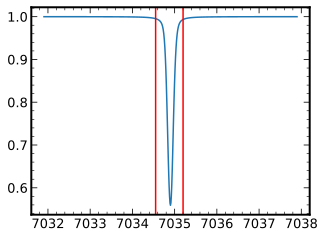

In [55]:
plt.plot(line_lams[4], sim_int_3d_norm_ar[4][0])
for lim in iag_int_lims[4,:]:
    plt.axvline(lim, color='r')
print(integrate.simps(y=1-yy, x=xx) * 1000)

In [57]:
get_line_eqw(linesobject=NLTE3d_lines, line=4, qmax=40, define_mask=iag_int_lims[4])

[13.523604494461969,
 15.111645171083861,
 15.000107047962622,
 14.637340220489982,
 13.602400658226891,
 11.62580572449437]

In [36]:
# fig, axs = plt.subplots(2,3, figsize=(15,8),squeeze=True)

# # for i, run in enumerate(ex_1d_eqw):
# #     axs[1,1].plot(sol_mus, ex_1d_eqw[:,i], '--o', label=round(test_cog.abnds[i],2))
# count = 0
# for col, ax in zip(range(len(major_krs)), axs.flatten()):

#     # ax.plot(sol_mus, eq_iag[col],'r--x', label='IAG')
#     # ax.set_xlabel('mu')
#     # ax.set_ylabel('Eq. width, mÅ')
#     # ax.set_title(f'IAG & 1D LTE eq. widths, λ={m3d_centre_wavelengths[col]}')
#     # for i, run in enumerate(LTE1d_cog.abnds):
#     #     ax.plot(sol_mus, eqwidths_1dlte[col,:,i], '--o', label=f'1D LTE {round(LTE1d_cog.abnds[i],2)}')

#     # plot the 3D NLTE EWs
    
#     if col==0 or col==3 or col==4:


#         ax.plot(sol_mus, eq_iag[col],'r--x', label='IAG')
#         ax.set_xlabel('mu')
#         ax.set_ylabel('Eq. width, mÅ')
#         ax.set_title(f'IAG & 1D LTE eq. widths, λ={m3d_centre_wavelengths[col]}')
#         for i, run in enumerate(LTE1d_cog.abnds):
#             ax.plot(sol_mus, eqwidths_1dlte[col,:,i], '--o', label=f'1D LTE {round(LTE1d_cog.abnds[i],2)}')

#         # plot the 3D NLTE EWs
#         ax.plot(sol_mus, eq_3DNLTE[count], label='NLTE')


#         count +=1
#     if col==4:
#         handles, labels = ax.get_legend_handles_labels()
#         fig.legend(handles, labels, loc=(0.8,0.1))


# plt.tight_layout()
# # plt.savefig('../plots/EWs_mus_IOSMET_withNLTE.pdf')

## Plot EWs after observed spectra processing

In [37]:
# fig, axs = plt.subplots(2,3, figsize=(15,10),squeeze=True)

# # for i, run in enumerate(ex_1d_eqw):
# #     axs[1,1].plot(sol_mus, ex_1d_eqw[:,i], '--o', label=round(test_cog.abnds[i],2))

# for col, ax in zip(range(len(major_krs)), axs.flatten()):

#     ax.plot(sol_mus, new_eq_iag[col],'r--x', label='IAG')
#     ax.set_xlabel('mu')
#     ax.set_ylabel('Eq. width, mÅ')
#     ax.set_title(f'IAG & 1D LTE eq. widths, λ={m3d_centre_wavelengths[col]}')
#     for i, run in enumerate(LTE1d_cog.abnds):
#         ax.plot(sol_mus, eqwidths_1dlte[col,:,i], '--o', label=round(LTE1d_cog.abnds[i],2))
#     ax.legend()


# plt.tight_layout()
# # plt.savefig('plots/IAG_ewq.pdf')

In [38]:
# fig, axs = plt.subplots(2,3, figsize=(15,8),squeeze=True)

# # for i, run in enumerate(ex_1d_eqw):
# #     axs[1,1].plot(sol_mus, ex_1d_eqw[:,i], '--o', label=round(test_cog.abnds[i],2))
# count = 0
# for col, ax in zip(range(len(major_krs)), axs.flatten()):

#     # ax.plot(sol_mus, eq_iag[col],'r--x', label='IAG')
#     # ax.set_xlabel('mu')
#     # ax.set_ylabel('Eq. width, mÅ')
#     # ax.set_title(f'IAG & 1D LTE eq. widths, λ={m3d_centre_wavelengths[col]}')
#     # for i, run in enumerate(LTE1d_cog.abnds):
#     #     ax.plot(sol_mus, eqwidths_1dlte[col,:,i], '--o', label=f'1D LTE {round(LTE1d_cog.abnds[i],2)}')

#     # plot the 3D NLTE EWs
    
#     if col==0 or col==3 or col==4:


#         ax.plot(sol_mus, new_eq_iag[col],'r--x', label='IAG')
#         ax.set_xlabel('mu')
#         ax.set_ylabel('Eq. width, mÅ')
#         ax.set_title(f'IAG & 1D LTE eq. widths, λ={m3d_centre_wavelengths[col]}')
#         for i, run in enumerate(LTE1d_cog.abnds):
#             ax.plot(sol_mus, eqwidths_1dlte[col,:,i], '--o', label=f'1D LTE {round(LTE1d_cog.abnds[i],2)}')

#         # plot the 3D NLTE EWs
#         ax.plot(sol_mus, NLTE3d_EWs[count], label='NLTE')


#         count +=1
#     if col==4:
#         handles, labels = ax.get_legend_handles_labels()
#         fig.legend(handles, labels, loc=(0.8,0.1))


# plt.tight_layout()
# # plt.savefig('../plots/EWs_mus_IOSMET_withNLTE_renormed.pdf')

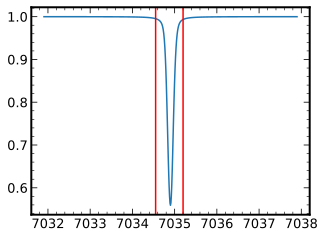

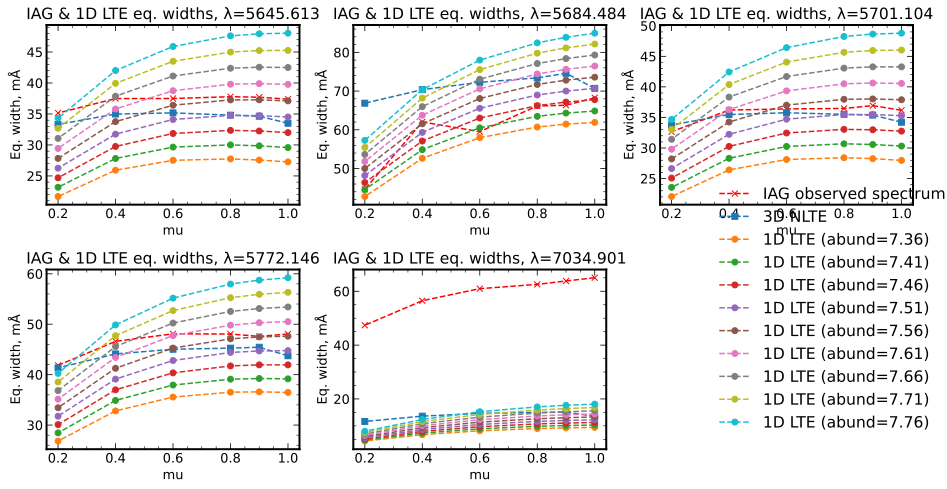

In [39]:
# M: make EWs vs mu plot with only one 1D LTE line
fig=plt.figure(figsize=(13,7))
for i in range(1, 6):
    fig.add_subplot(2, 3, i)
    # plot observed spectra EWs
    plt.plot(sol_mus, new_eq_iag[i-1],'r--x', label='IAG observed spectrum')
    # plot the 3D NLTE EWs
    plt.plot(sol_mus, NLTE3d_EWs[i-1], '--s', label='3D NLTE')
    # plot 1D LTE EWs for abund=7.56 from CoG array of runs
    # central_abund_ind=4
    # plt.plot(sol_mus, eqwidths_1dlte[i-1,:,central_abund_ind], '--o', label=f'1D LTE (abund={round(LTE1d_cog.abnds[central_abund_ind],2)})')
    
    for j, abd in enumerate(LTE1d_cog.abnds):
        plt.plot(sol_mus, eqwidths_1dlte[i-1,:,j], '--o', label=f'1D LTE (abund={round(LTE1d_cog.abnds[j],2)})')

    
    plt.xlabel('mu')
    plt.ylabel('Eq. width, mÅ')
    plt.title(f'IAG & 1D LTE eq. widths, λ={m3d_centre_wavelengths[i-1]}')
    # if i==5:
        # handles, labels = ax.get_legend_handles_labels()
        # fig.legend(handles, labels, loc=(0.8,0.1))
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.75,0.10), fontsize='large')

plt.tight_layout()
# plt.savefig('../plots/EWs_renorm_allabs.pdf')

In [50]:
NLTE3d_EWs[-1]

[13.523604494461969,
 15.111645171083861,
 15.000107047962622,
 14.637340220489982,
 13.602400658226891,
 11.62580572449437]

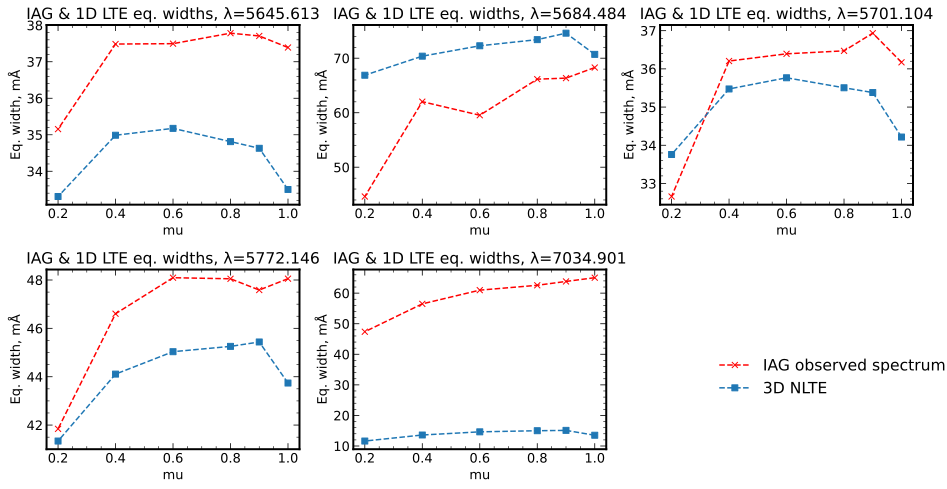

In [42]:
# # EWs vs mu plot with Amarsi atom file 1D LTE
# fig=plt.figure(figsize=(13,7))
# for i in range(1, 6):
#     fig.add_subplot(2, 3, i)
#     # plot observed spectra EWs
#     plt.plot(sol_mus, new_eq_iag[i-1],'r--x', label='IAG observed spectrum')
#     # plot the 3D NLTE EWs
#     plt.plot(sol_mus, NLTE3d_EWs[i-1], '--s', label='3D NLTE')
#     # plot 1D LTE EWs for abund=7.56 from CoG array of runs
#     # plt.plot(sol_mus, Ama_1DLTE_EWs[i-1], '--o', label=f'1D LTE Amarsi F')

    
#     plt.xlabel('mu')
#     plt.ylabel('Eq. width, mÅ')
#     plt.title(f'IAG & 1D LTE eq. widths, λ={m3d_centre_wavelengths[i-1]}')
#     # if i==5:
#         # handles, labels = ax.get_legend_handles_labels()
#         # fig.legend(handles, labels, loc=(0.8,0.1))
# handles, labels = plt.gca().get_legend_handles_labels()
# fig.legend(handles, labels, loc=(0.75,0.17), fontsize='large')
# # plt.savefig('../plots/EWs_renorm_3linesAmarsi.pdf')

# plt.tight_layout()

In [34]:
# plt.scatter(eqwidths_1dlte[0,0,:], LTE1d_cog.abnds)
# plt.vlines(new_eq_iag[0,0], 7.3, 7.8)

## Interpolate  and plot abundances for observed spectra

### Interpolate and save abundances 
(commented out now as to just read in only pre-calculted abunds - uncomment to run again)

In [37]:
def interp_abund(lte1d_lines_eq, lte1d_abundances, iag_eq):
    interpd_sol_abunds = np.zeros((len(lte1d_lines_eq), len(sol_mus)), dtype=object)
    for i, line_eq in enumerate(lte1d_lines_eq):
        for j, mu in enumerate(sol_mus):
            x = lte1d_lines_eq[i,j,:]
            y = lte1d_abundances
            f = interpolate.interp1d(x,y,fill_value='extrapolate')

            interpd_sol_abunds[i,j] = f(iag_eq[i,j])
    return interpd_sol_abunds

In [38]:
iag_1dlte_abunds = interp_abund(np.take(eqwidths_1dlte, [0,3,4], axis=0), LTE1d_cog.abnds, np.take(new_eq_iag, [0,3,4], axis=0))
iag_1dlte_abunds = interp_abund(eqwidths_1dlte,  LTE1d_cog.abnds, new_eq_iag)

In [39]:
# # NLTE3Dcorrections = np.load('../mdata/3DNLTE_abund_corr_old30_newang.npy')
# NLTE3Dcorrections = np.load('../mdata/3DNLTE_abund_corr_no_iosmet_5wls.npy')
# NLTE1Dcorrections = np.load('../mdata/1DNLTE_abund_corr_no_iosmet_5wls.npy')
LTE3Dcorrections = np.load('../mdata/3DLTE_abund_corr_2404.npy')



In [40]:
# # iag_3DNLTE_corrected_abund = np.add(iag_1dlte_abunds, NLTE3Dcorrections.reshape(3,6))
# iag_3DNLTE_corrected_abund = np.add(iag_1dlte_abunds, NLTE3Dcorrections)
# iag_1DNLTE_corrected_abund = np.add(iag_1dlte_abunds, NLTE1Dcorrections)
iag_3DLTE_corrected_abund = np.add(iag_1dlte_abunds, LTE3Dcorrections)

In [41]:
# # save calculated abundances
# with open('../mdata/1d_lte_abunds', 'wb') as f:
#     pickle.dump(iag_1dlte_abunds, f)
# with open('../mdata/3DNLTE_corrected_abunds', 'wb') as f:
#     pickle.dump(iag_3DNLTE_corrected_abund, f)

# with open('../mdata/1DNLTE_corrected_abunds', 'wb') as f:
#     pickle.dump(iag_1DNLTE_corrected_abund, f)

# with open('../mdata/3DLTE_corrected_abunds', 'wb') as f:
#     pickle.dump(iag_3DLTE_corrected_abund, f)
# with open('../mdata/3DLTE_corrected_abunds', 'wb') as f:
#     pickle.dump(iag_3DLTE_corrected_abund, f)

In [42]:
with open('../mdata/3DNLTE_corrected_abunds', "rb") as f:
    iag_3DNLTE_corrected_abund = pickle.load(f)
with open('../mdata/1DNLTE_corrected_abunds', "rb") as f:
    iag_1DNLTE_corrected_abund = pickle.load(f)
with open('../mdata/3DLTE_corrected_abunds', "rb") as f:
    iag_3DLTE_corrected_abund = pickle.load(f)
with open('../mdata/1d_lte_abunds', "rb") as f:
    iag_1DLTE_abund = pickle.load(f)


### Plot 1D LTE abundances and added corrections

#### 1D NLTE

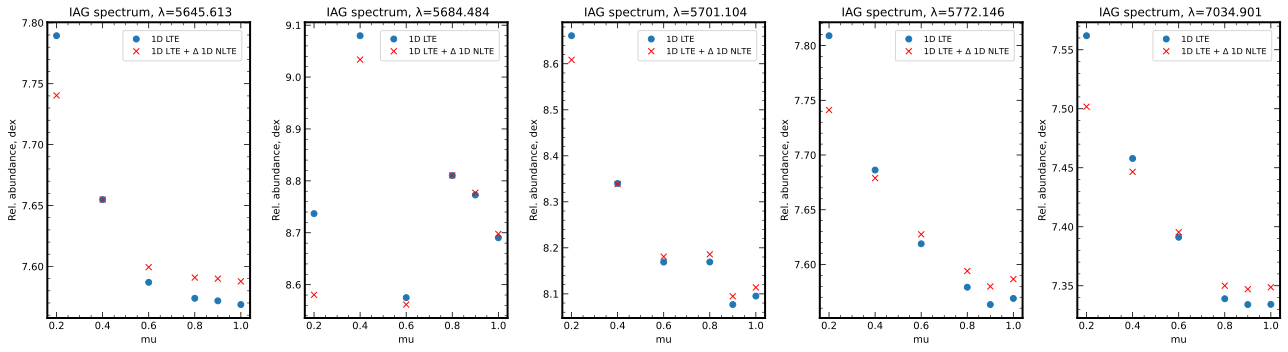

In [43]:
fig, ax = plt.subplots(1,len(iag_1DLTE_abund), figsize=(18,5))

for i, line in enumerate(iag_1DLTE_abund):
    ax[i].plot(sol_mus, iag_1DLTE_abund[i], 'o', label='1D LTE')
    # ax[i].plot(sol_mus, iag_3DNLTE_corrected_abund[i], 'x', label='1D LTE + $\Delta$ 3D NLTE')
    ax[i].plot(sol_mus, iag_1DNLTE_corrected_abund[i], 'x', label='1D LTE + $\Delta$ 1D NLTE', color='r')


    ax[i].set_xlabel('mu')
    ax[i].set_ylabel('Rel. abundance, dex')
    # ax[i].set_title(f' IAG spectrum, λ={np.take(m3d_centre_wavelengths,[0,3,4])[i]}')
    ax[i].set_title(f' IAG spectrum, λ={m3d_centre_wavelengths[i]}')

    # ax[i].set_ylim(7.46, 7.65)
    ax[i].legend(loc='best',frameon=1, fontsize='small')
plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.27, hspace=None)
# fig.savefig('../plots/abnd_calc_1dNLTE.pdf')

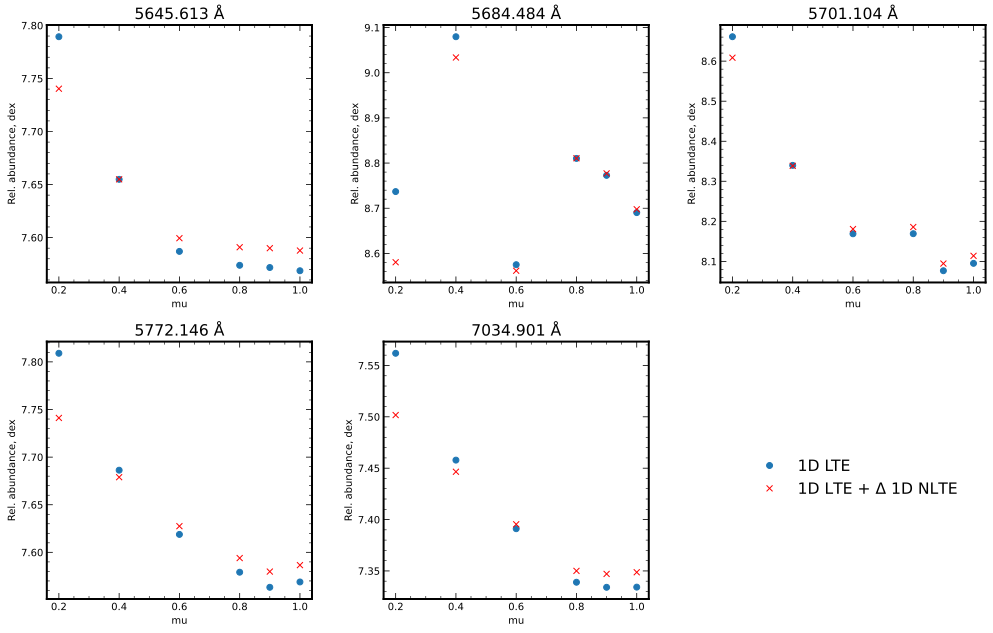

In [44]:
fig, ax = plt.subplots(2,3, figsize=(14,9))
v = product(range(2),range(3))
plt.rcParams.update({'font.size': 13})

for i, line in enumerate(v):
    if i==len(iag_1DLTE_abund):
        fig.delaxes(ax[line])
        break
    ax[line].plot(sol_mus, iag_1DLTE_abund[i], 'o', label='1D LTE')
    # ax[i].plot(sol_mus, iag_3DNLTE_corrected_abund[i], 'x', label='1D LTE + $\Delta$ 3D NLTE')
    ax[line].plot(sol_mus, iag_1DNLTE_corrected_abund[i], 'x', label='1D LTE + $\Delta$ 1D NLTE', color='r')

    ax[line].set_xlabel('mu')
    ax[line].set_ylabel('Rel. abundance, dex')
    # a[i].set_title(f' IAG spectrum, λ={np.take(m3d_centre_wavelengths,[0,3,4])[i]}')
    ax[line].set_title(f'{m3d_centre_wavelengths[i]} Å')
    # a[i].set_ylim(7.46, 7.65)
    # ax[line].legend(loc='best',frameon=1, fontsize='small')
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.75,0.20), fontsize='large')

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.27, hspace=None)
# fig.savefig('../plots/abnd_calc_3dNLTE_3x2.pdf')

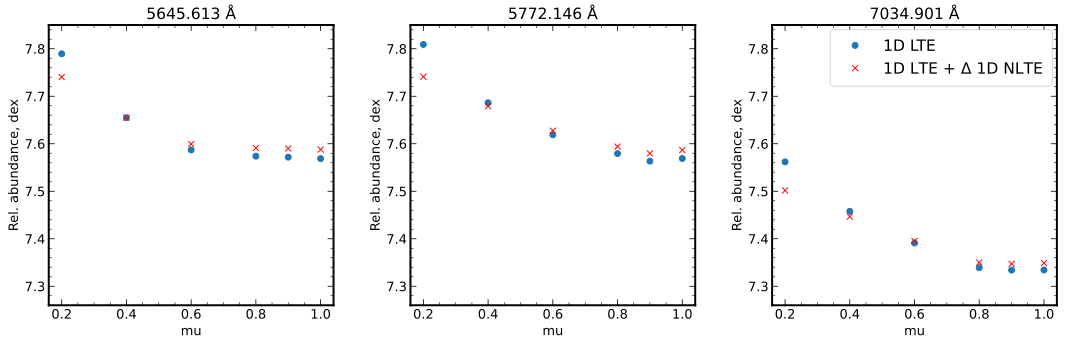

In [45]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
# v = product(range(2),range(3))
plt.rcParams.update({'font.size': 13})

for i, line in enumerate([0,3,4]):
    ax[i].plot(sol_mus, iag_1DLTE_abund[line], 'o', label='1D LTE')
    # ax[i].plot(sol_mus, iag_3DNLTE_corrected_abund[i], 'x', label='1D LTE + $\Delta$ 3D NLTE')
    ax[i].plot(sol_mus, iag_1DNLTE_corrected_abund[line], 'x', label='1D LTE + $\Delta$ 1D NLTE', color='r')

    ax[i].set_xlabel('mu')
    ax[i].set_ylabel('Rel. abundance, dex')
    # a[i].set_title(f' IAG spectrum, λ={np.take(m3d_centre_wavelengths,[0,3,4])[i]}')
    ax[i].set_title(f'{m3d_centre_wavelengths[line]} Å')
    ax[i].set_ylim(7.26, 7.85)
    # ax[line].legend(loc='best',frameon=1, fontsize='small')
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.78,0.75), fontsize='large',frameon='True')

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.27, hspace=None)
# fig.savefig('../plots/abnd_calc_1dNLTE_3lines_zoomout.pdf')

#### 3D NLTE

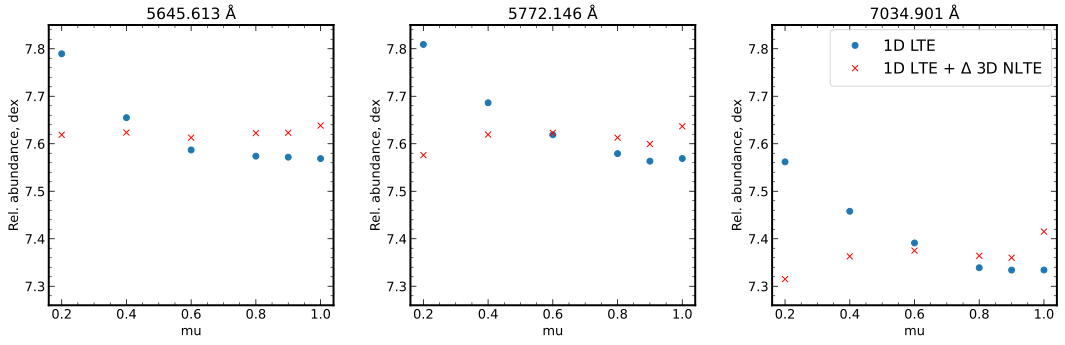

In [46]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
# v = product(range(2),range(3))
plt.rcParams.update({'font.size': 13})

for i, line in enumerate([0,3,4]):
    ax[i].plot(sol_mus, iag_1DLTE_abund[line], 'o', label='1D LTE')
    ax[i].plot(sol_mus, iag_3DNLTE_corrected_abund[line], 'x', label='1D LTE + $\Delta$ 3D NLTE', color='r')

    ax[i].set_xlabel('mu')
    ax[i].set_ylabel('Rel. abundance, dex')
    ax[i].set_title(f'{m3d_centre_wavelengths[line]} Å')
    ax[i].set_ylim(7.26, 7.85)

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.78,0.75), fontsize='large',frameon='True')

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.27, hspace=None)
# fig.savefig('../plots/abnd_calc_3dNLTE_3lines_zoomout.pdf')

#### 3D LTE

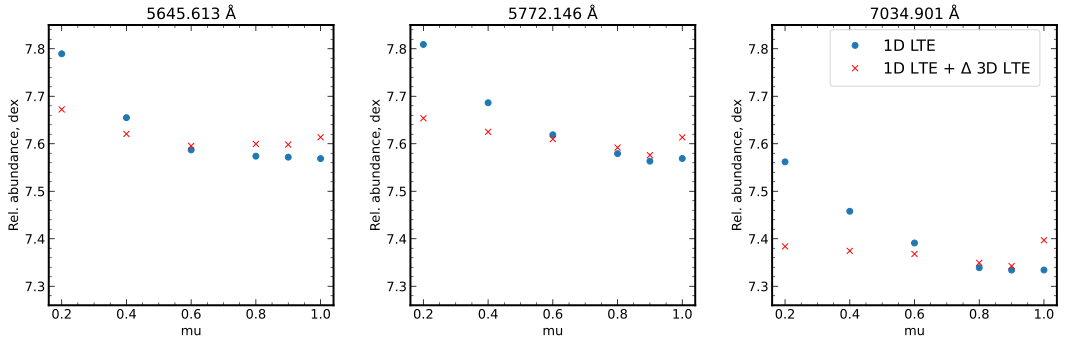

In [47]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
# v = product(range(2),range(3))
plt.rcParams.update({'font.size': 13})

for i, line in enumerate([0,3,4]):
    ax[i].plot(sol_mus, iag_1DLTE_abund[line], 'o', label='1D LTE')
    ax[i].plot(sol_mus, iag_3DLTE_corrected_abund[line], 'x', label='1D LTE + $\Delta$ 3D LTE', color='r')

    ax[i].set_xlabel('mu')
    ax[i].set_ylabel('Rel. abundance, dex')
    ax[i].set_title(f'{m3d_centre_wavelengths[line]} Å')
    ax[i].set_ylim(7.26, 7.85)

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.78,0.75), fontsize='large',frameon='True')

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.27, hspace=None)

#### Plot per spectral line

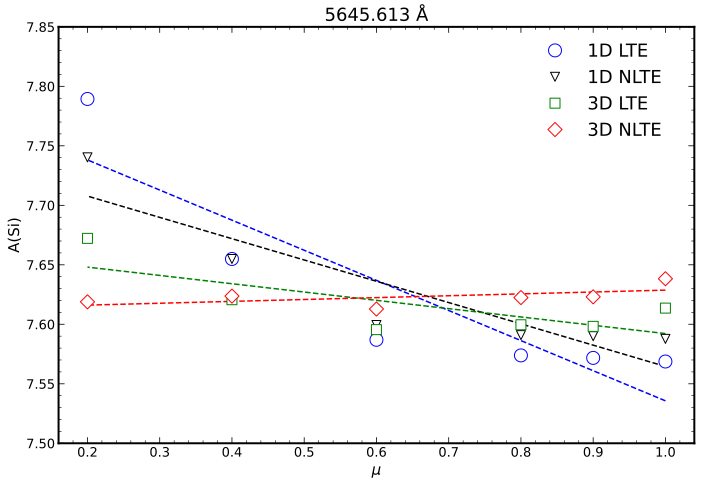

In [48]:
fig, ax = plt.subplots(1, figsize=(10,7))

plt.rcParams.update({'font.size': 15})
line = 0


poly1d_fn_1DLTE = np.poly1d(np.polyfit(sol_mus,np.array([i for i in iag_1DLTE_abund[line]]),1))
poly1d_fn_1DNLTE = np.poly1d(np.polyfit(sol_mus,np.array([i for i in iag_1DNLTE_corrected_abund[line]]),1))
poly1d_fn_3DLTE = np.poly1d(np.polyfit(sol_mus,np.array([i for i in iag_3DLTE_corrected_abund[line]]),1)) 
poly1d_fn_3DNLTE = np.poly1d(np.polyfit(sol_mus,np.array([i for i in iag_3DNLTE_corrected_abund[line]]),1)) 

ax.plot(sol_mus, iag_1DLTE_abund[line], 'o', markerfacecolor='white', color='b', markersize=13, zorder=10,label='1D LTE')
ax.plot(sol_mus, iag_1DNLTE_corrected_abund[line], 'v', markerfacecolor='white', markersize=9,zorder=100, label='1D NLTE', color='k')
ax.plot(sol_mus, iag_3DLTE_corrected_abund[line], 's', markerfacecolor='white', markersize=10,zorder=1000, label='3D LTE', color='g')
ax.plot(sol_mus, iag_3DNLTE_corrected_abund[line], 'D', markerfacecolor='white', markersize=10,zorder=10000, label='3D NLTE', color='r')

ax.plot(sol_mus, poly1d_fn_1DLTE(sol_mus), '--', color='b')
ax.plot(sol_mus, poly1d_fn_1DNLTE(sol_mus), '--', color='k')
ax.plot(sol_mus, poly1d_fn_3DLTE(sol_mus), '--', color='g')
ax.plot(sol_mus, poly1d_fn_3DNLTE(sol_mus), '--', color='r')



ax.set_xlabel('$\mu$', fontsize=15)
ax.set_ylabel('A(Si)', fontsize=15)
ax.set_title(f'{m3d_centre_wavelengths[line]} Å')
ax.set_ylim(7.5, 7.85)


# handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(fontsize='large', loc=(0.75,0.69))

plt.tight_layout()
# fig.savefig('../plots/abnd_calc_5645.pdf')

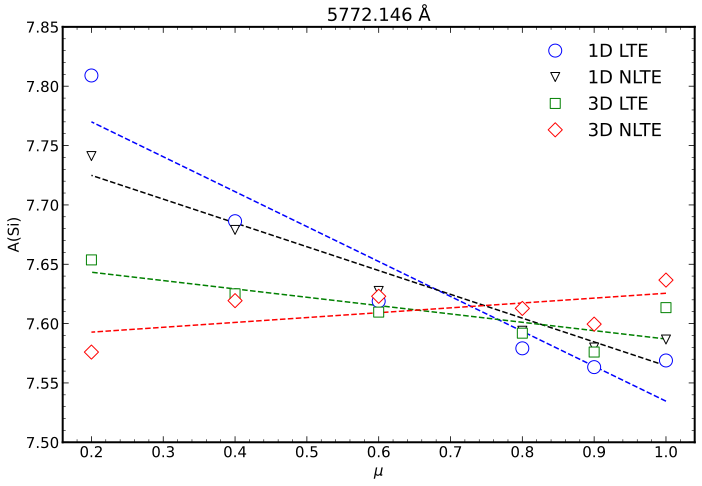

In [49]:
fig, ax = plt.subplots(1, figsize=(10,7))

plt.rcParams.update({'font.size': 15})
line = 3


poly1d_fn_1DLTE = np.poly1d(np.polyfit(sol_mus,np.array([i for i in iag_1DLTE_abund[line]]),1))
poly1d_fn_1DNLTE = np.poly1d(np.polyfit(sol_mus,np.array([i for i in iag_1DNLTE_corrected_abund[line]]),1))
poly1d_fn_3DLTE = np.poly1d(np.polyfit(sol_mus,np.array([i for i in iag_3DLTE_corrected_abund[line]]),1)) 
poly1d_fn_3DNLTE = np.poly1d(np.polyfit(sol_mus,np.array([i for i in iag_3DNLTE_corrected_abund[line]]),1)) 

ax.plot(sol_mus, iag_1DLTE_abund[line], 'o', markerfacecolor='white', color='b', markersize=13, zorder=10,label='1D LTE')
ax.plot(sol_mus, iag_1DNLTE_corrected_abund[line], 'v', markerfacecolor='white', markersize=9,zorder=100, label='1D NLTE', color='k')
ax.plot(sol_mus, iag_3DLTE_corrected_abund[line], 's', markerfacecolor='white', markersize=10,zorder=1000, label='3D LTE', color='g')
ax.plot(sol_mus, iag_3DNLTE_corrected_abund[line], 'D', markerfacecolor='white', markersize=10,zorder=10000, label='3D NLTE', color='r')

ax.plot(sol_mus, poly1d_fn_1DLTE(sol_mus), '--', color='b')
ax.plot(sol_mus, poly1d_fn_1DNLTE(sol_mus), '--', color='k')
ax.plot(sol_mus, poly1d_fn_3DLTE(sol_mus), '--', color='g')
ax.plot(sol_mus, poly1d_fn_3DNLTE(sol_mus), '--', color='r')



ax.set_xlabel('$\mu$', fontsize=15)
ax.set_ylabel('A(Si)', fontsize=15)
ax.set_title(f'{m3d_centre_wavelengths[line]} Å')
ax.set_ylim(7.5, 7.85)


# handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(fontsize='large', loc=(0.75,0.69))

plt.tight_layout()
# fig.savefig('../plots/abnd_calc_5772.pdf')

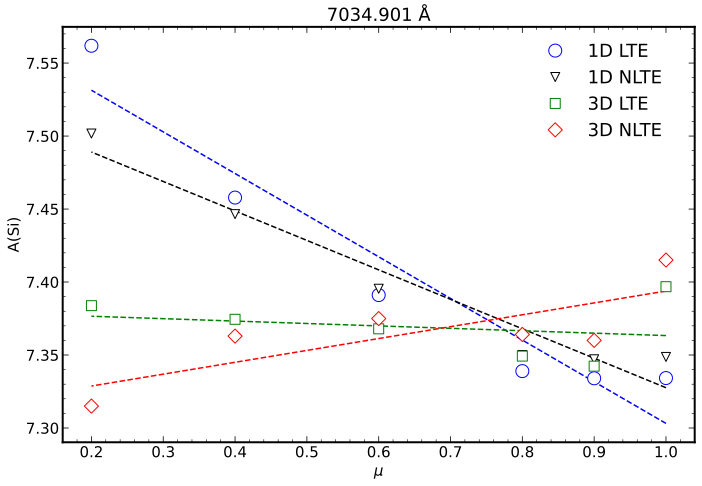

In [50]:
fig, ax = plt.subplots(1, figsize=(10,7))

plt.rcParams.update({'font.size': 15})
line = 4


poly1d_fn_1DLTE = np.poly1d(np.polyfit(sol_mus,np.array([i for i in iag_1DLTE_abund[line]]),1))
poly1d_fn_1DNLTE = np.poly1d(np.polyfit(sol_mus,np.array([i for i in iag_1DNLTE_corrected_abund[line]]),1))
poly1d_fn_3DLTE = np.poly1d(np.polyfit(sol_mus,np.array([i for i in iag_3DLTE_corrected_abund[line]]),1)) 
poly1d_fn_3DNLTE = np.poly1d(np.polyfit(sol_mus,np.array([i for i in iag_3DNLTE_corrected_abund[line]]),1)) 

ax.plot(sol_mus, iag_1DLTE_abund[line], 'o', markerfacecolor='white', color='b', markersize=13, zorder=10,label='1D LTE')
ax.plot(sol_mus, iag_1DNLTE_corrected_abund[line], 'v', markerfacecolor='white', markersize=9,zorder=100, label='1D NLTE', color='k')
ax.plot(sol_mus, iag_3DLTE_corrected_abund[line], 's', markerfacecolor='white', markersize=10,zorder=1000, label='3D LTE', color='g')
ax.plot(sol_mus, iag_3DNLTE_corrected_abund[line], 'D', markerfacecolor='white', markersize=10,zorder=10000, label='3D NLTE', color='r')

ax.plot(sol_mus, poly1d_fn_1DLTE(sol_mus), '--', color='b')
ax.plot(sol_mus, poly1d_fn_1DNLTE(sol_mus), '--', color='k')
ax.plot(sol_mus, poly1d_fn_3DLTE(sol_mus), '--', color='g')
ax.plot(sol_mus, poly1d_fn_3DNLTE(sol_mus), '--', color='r')



ax.set_xlabel('$\mu$', fontsize=15)
ax.set_ylabel('A(Si)', fontsize=15)
ax.set_title(f'{m3d_centre_wavelengths[line]} Å')
# ax.set_ylim(7.5, 7.85)


# handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(fontsize='large', loc=(0.75,0.69))

plt.tight_layout()
fig.savefig('../plots/abnd_calc_7034.pdf')

## Plot centre-limb difference in line profiles for 1D and 3D NLTE relative to 1D LTE

In [46]:
# Top one here defined above
# NLTE3d_EWs = [get_line_eqw(linesobject=NLTE3d_lines, line=thisline, qmax=3.5) for thisline in range(len((NLTE3d_lines)))]
LTE1D_EWs = [get_line_eqw(linesobject=linesobj[0], line=thisline, qmax=3.5) for thisline in range(len((linesobj[0])))] ### ADD LTE 1D EWs (problem where linesobj is defined twice differently in this script) - then add line ew to the legend for the line profile plot
NLTE1D_EWs = [get_line_eqw(linesobject=line_obj_1DNLTE, line=thisline, qmax=3.5) for thisline in range(len((line_obj_1DNLTE)))]
LTE3D_EWs = [get_line_eqw(linesobject=lines_obj_3DLTE, line=thisline, qmax=3.5) for thisline in range(len((lines_obj_3DLTE)))]

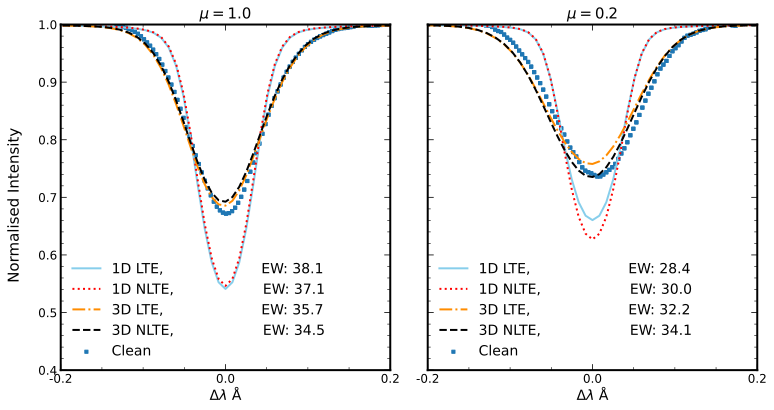

In [75]:
fig, ax = plt.subplots(1,2, figsize=(11,6), sharey='row')
line_kr = 2
# for i, thismu in enumerate([sol_mus[0], sol_mus[-1]]):
for i in [0,-1]:
            
        # ax[i].plot(*convol(line_lams[line_kr], sim_int_1d_norm_ar[line_kr][i], zeta_rt=3), label=f'1D LTE, EW: {LTE1D_EWs[line_kr][i]:.1f}', color='skyblue', linestyle='-',linewidth='2')
        ax[i].plot(line_lams[line_kr], sim_int_1d_norm_ar[line_kr][i], label=f'1D LTE,                      EW: {LTE1D_EWs[line_kr][i]:.1f}', color='skyblue', linestyle='-',linewidth='2')

        ax[i].plot(line_lams[line_kr], sim_int_1dnlte_norm_ar[line_kr][i], label=f'1D NLTE,                    EW: {NLTE1D_EWs[line_kr][i]:.1f}', color='r', linestyle=':',linewidth='2')

        ax[i].plot(line_lams[line_kr], sim_int_3dlte_norm_ar[line_kr][i], label=f'3D LTE,                      EW: {LTE3D_EWs[line_kr][i]:.1f}', color='darkorange', linestyle='-.',linewidth='2')

        ax[i].plot(line_lams[line_kr], sim_int_3d_norm_ar[line_kr][i], label=f'3D NLTE,                    EW: {NLTE3d_EWs[line_kr][i]:.1f}', color='k', linestyle='--',linewidth='2')

        ax[i].scatter(sol_lam_range_list[line_kr,i], sol_int_renorm[line_kr,i],  label='Clean', marker='s', s=10)
        ax[i].set_title(f'$\mu = {sol_mus[i]:.1f}$', fontsize=15)
        
        ax[i].set_xlim((m3d_centre_wavelengths[line_kr]-0.2), (m3d_centre_wavelengths[line_kr]+0.2))
        ax[i].set_xticks(ticks=np.linspace(m3d_centre_wavelengths[line_kr]-0.2, m3d_centre_wavelengths[line_kr]+0.2,3) ,labels=np.linspace(-0.2,0.2,3))
        ax[i].tick_params(axis='both', which='major', labelsize=12)


        ax[i].set_ylim(0.4, 1)
        ax[i].set_xlabel('$\Delta \lambda$ Å', fontsize=14)
        ax[i].legend(fontsize=14, loc=(0.01,0.01))

        
fig.supylabel('Normalised Intensity', fontsize=15)
plt.tight_layout()
      
# fig.savefig('../plots/OneLineLiProf1D3D.png')

In [77]:
sol_int_renorm[2,0]

array([1.        , 0.99829759, 0.99635521, 0.99439504, 0.99251464,
       0.99030154, 0.98744438, 0.98397192, 0.97960896, 0.97435117,
       0.96893477, 0.96321847, 0.95635099, 0.9485605 , 0.94027006,
       0.93041009, 0.91933756, 0.90795692, 0.89574996, 0.88298349,
       0.86920694, 0.85372871, 0.83799679, 0.82210726, 0.80580658,
       0.78928694, 0.77294267, 0.75789128, 0.74321385, 0.72878952,
       0.71568817, 0.70351134, 0.69266447, 0.68388156, 0.67747614,
       0.67352949, 0.67175008, 0.67269785, 0.67608343, 0.68195933,
       0.69053142, 0.70094197, 0.71344642, 0.72836835, 0.74443484,
       0.76048939, 0.77668638, 0.79339269, 0.81033011, 0.82726202,
       0.84351718, 0.85868693, 0.87220068, 0.88398536, 0.89598297,
       0.9078302 , 0.91792332, 0.92704091, 0.9352475 , 0.94243867,
       0.94909834, 0.95537818, 0.96112076, 0.96589448, 0.96996372,
       0.97355535, 0.97669075, 0.97949131, 0.98175941, 0.98397434,
       0.98637405, 0.98873163, 0.99069757, 0.99222955, 0.99347

### 1D LTE line comparison with mu 

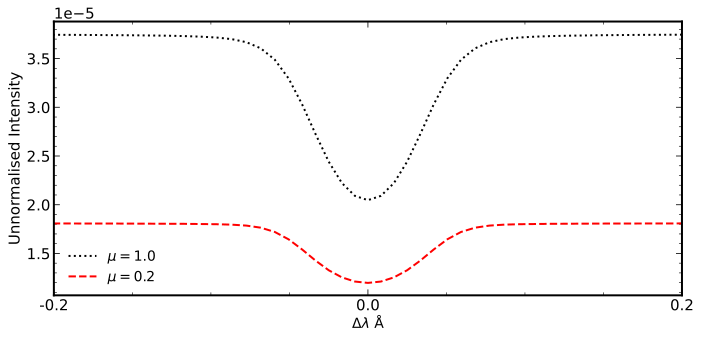

In [48]:
fig, ax = plt.subplots(1, figsize=(10,5))
line_kr = 0
styles = [':', '--']
colours = ['k', 'r']
for i in [0,-1]:
    ax.plot(line_lams[line_kr], sim_int_1d_dict[line_kr][i], label=fr'$\mu = {sol_mus[i]:.1f}$', linestyle=styles[i], color=colours[i],linewidth='2')

ax.set_xlabel('$\Delta \lambda$ Å', fontsize=14)
ax.legend(fontsize=14, loc=(0.01,0.01))
# ax.set_title(f'$\mu = {sol_mus[i]:.1f}$', fontsize=15)
ax.set_xlim((m3d_centre_wavelengths[line_kr]-0.2), (m3d_centre_wavelengths[line_kr]+0.2))
ax.set_xticks(ticks=np.linspace(m3d_centre_wavelengths[line_kr]-0.2, m3d_centre_wavelengths[line_kr]+0.2,3) ,labels=np.linspace(-0.2,0.2,3))
# ax.tick_params(axis='both', which='major', labelsize=1)
        
ax.set_ylabel('Unnormalised Intensity', fontsize=15)
plt.tight_layout()
      
# fig.savefig('../plots/Unnorm1DLTE.png')

### 3D NLTE line comparison with mu 

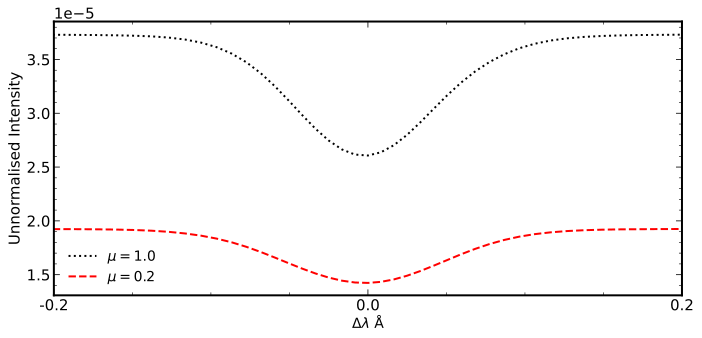

In [49]:
fig, ax = plt.subplots(1, figsize=(10,5))
line_kr = 0
styles = [':', '--']
colours = ['k', 'r']
for i in [0,-1]:
    ax.plot(line_lams[line_kr], sim_int_3dnlte_dict[line_kr][i], label=fr'$\mu = {sol_mus[i]:.1f}$', linestyle=styles[i], color=colours[i],linewidth='2')

ax.set_xlabel('$\Delta \lambda$ Å', fontsize=14)
ax.legend(fontsize=14, loc=(0.01,0.01))
# ax.set_title(f'$\mu = {sol_mus[i]:.1f}$', fontsize=15)
ax.set_xlim((m3d_centre_wavelengths[line_kr]-0.2), (m3d_centre_wavelengths[line_kr]+0.2))
ax.set_xticks(ticks=np.linspace(m3d_centre_wavelengths[line_kr]-0.2, m3d_centre_wavelengths[line_kr]+0.2,3) ,labels=np.linspace(-0.2,0.2,3))
# ax.tick_params(axis='both', which='major', labelsize=1)
        
ax.set_ylabel('Unnormalised Intensity', fontsize=15)
plt.tight_layout()
      
# fig.savefig('../plots/Unnorm3DNLTE.png')

### 3D LTE line profile comparison with mu

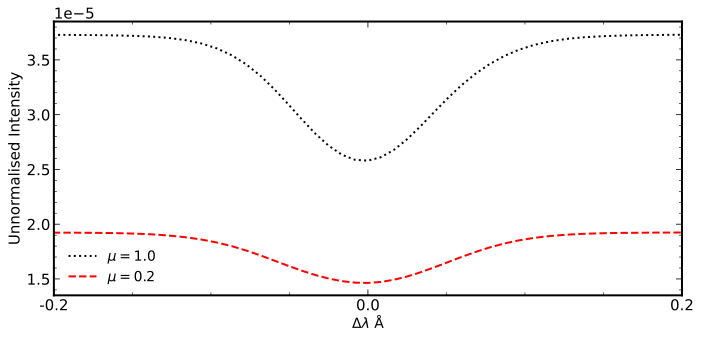

In [50]:
fig, ax = plt.subplots(1, figsize=(10,5))
line_kr = 0
styles = [':', '--']
colours = ['k', 'r']
for i in [0,-1]:
    ax.plot(line_lams[line_kr], sim_int_3dlte_dict[line_kr][i], label=fr'$\mu = {sol_mus[i]:.1f}$', linestyle=styles[i], color=colours[i],linewidth='2')

ax.set_xlabel('$\Delta \lambda$ Å', fontsize=14)
ax.legend(fontsize=14, loc=(0.01,0.01))
# ax.set_title(f'$\mu = {sol_mus[i]:.1f}$', fontsize=15)
ax.set_xlim((m3d_centre_wavelengths[line_kr]-0.2), (m3d_centre_wavelengths[line_kr]+0.2))
ax.set_xticks(ticks=np.linspace(m3d_centre_wavelengths[line_kr]-0.2, m3d_centre_wavelengths[line_kr]+0.2,3) ,labels=np.linspace(-0.2,0.2,3))
# ax.tick_params(axis='both', which='major', labelsize=1)
        
ax.set_ylabel('Unnormalised Intensity', fontsize=15)
plt.tight_layout()
      
# fig.savefig('../plots/Unnorm3DLTE.png')